This section focuses on explaining how Decision Trees were used in this project.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn import tree
from IPython.display import Image
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import warnings


# Model Introduction

A decision tree is a type of supervised machine learning algorithm used to categorize or make predictions based on how a previous set of questions were answered. The model is a form of supervised learning, meaning that the model is trained and tested on a set of data that contains the desired categorization.The decision tree is like a tree with nodes. The branches depend on a number of factors. It splits data into branches like these till it achieves a threshold value. 

A simple example to further understand decision trees is predicting whether or not a person will show up to an outdoor football game based on several whether related factors. The example is visualized below: 

![](../img/Decision_tree.png)

As we move down the hierarchical structure of the tree (top to bottom), more information is gained and the ability to predict the outcome becomes easier. The above example is a tree that has a depth of 2 (representing only 2 questions asked), but other problems (like my project which is discussed in the next paragraphs) are harder to solve and have many more variables, which consequently cause the tree to go deeper.

# Model Use in project

Unlike the Naive Bayes model, which was used to predict a song's era (50s,60s,70s, etc.), I decided to use decision trees for a different more impactful purpose. I used decision trees to predict whether or not a certain song would make it to a user's playlist based on their Spotify playlist (this user was me at this stage of the project). Also, at the end of this page is a section called 'Model impacts' which discusses how this model could be used in a production environment and what problem does it solve. 



# Data collection and cleaning

Since the problem statement for this section changed, I needed to gather additional data to accommodate for that and gather additional data that fits the new problem. As previously mentioned, the goal of this section was to build a classifier (recommender) that predicts whether or not a certain song would make it to my playlist based on several audio related features. To do so, i combined my own playlist with 3 other playlists full of songs that are not in my playlist to have a final playlist that has mix of in playlist (i.e would be recommended to me) songs and not in playlist (i.e not recommended) songs. 

In [3]:
# The required data for this section are: 
# 1) The Billboard's top 100 between the years 1950 and 2021
# 2) My playlist's audio data that will be used to build a recommender (Gathered using Exportify)
# 3) Three additional playlists of songs that are not in my playlist. This is done to have a good mix of songs that are and 
# that are not in my playlist to build a classifier

df_billboard = pd.read_csv('/Users/anthonymoubarak/Desktop/anly-501-project-anthonymoub/501-project-website/Data/final_df.csv')
df_playlist = pd.read_csv('/Users/anthonymoubarak/Desktop/anly-501-project-anthonymoub/501-project-website/Data/anthony_music.csv')
df_rnb = pd.read_csv('/Users/anthonymoubarak/Desktop/anly-501-project-anthonymoub/501-project-website/Data/rnb.csv' ,  on_bad_lines='skip')
df_hiphop = pd.read_csv('/Users/anthonymoubarak/Desktop/anly-501-project-anthonymoub/501-project-website/Data/techno.csv' ,  on_bad_lines='skip')
df_techno = pd.read_csv('/Users/anthonymoubarak/Desktop/anly-501-project-anthonymoub/501-project-website/Data/hiphop.csv',  on_bad_lines='skip')

In [4]:
# Start by cleaning my playlist 
# Drop useless columns from playlist data 
warnings.filterwarnings('ignore')
useless_columns = ['Spotify ID' ,'Popularity','Artist IDs', 'Album Name', 'Added By', 'Added At']
df_playlist = df_playlist.drop(columns = useless_columns)

# Rename the release date column to year (to have consistency between both data frames)
df_playlist = df_playlist.rename(columns={"Release Date": "year" , "Track Name":"title"})

# Change the year format to the same format of the year column in the billboard playlist 

for i in np.arange(0,len(df_playlist)):
    try:
        df_playlist['year'][i] = int(df_playlist['year'][i].split('-')[0])
    except:
        continue

# The Genres column needs to be filtered down to one entry per song, meaning that a song tagged with the following genres [alternative metal,nu metal,post-grunge]
# should be filtered down to only "Metal". This is a necessary step to have better EDA.

for i in np.arange(0,len(df_playlist)):

     try:
          if ('metal' in df_playlist['Genres'][i].lower()) | ('rock' in df_playlist['Genres'][i].lower()):
               df_playlist['Genres'][i] = 'Metal/rock'
               
          elif 'rap' in df_playlist['Genres'][i].lower():
               df_playlist['Genres'][i] = 'Rap'
          
          elif ('indie' in df_playlist['Genres'][i].lower()) | ('pixie' in df_playlist['Genres'][i].lower()):
               df_playlist['Genres'][i] = 'Indie'
               
          elif 'jazz' in df_playlist['Genres'][i].lower():
               df_playlist['Genres'][i] = 'Jazz'

          elif 'punk' in df_playlist['Genres'][i].lower():
               df_playlist['Genres'][i] = 'Punk'

          else:
               df_playlist['Genres'][i] = 'Other'


     except:
          continue


In [5]:
# Cleaning all other playlists
warnings.filterwarnings('ignore')
df_rnb = pd.read_csv('/Users/anthonymoubarak/Desktop/anly-501-project-anthonymoub/501-project-website/Data/rnb.csv' ,  on_bad_lines='skip').reset_index()
df_hiphop = pd.read_csv('/Users/anthonymoubarak/Desktop/anly-501-project-anthonymoub/501-project-website/Data/techno.csv' ,  on_bad_lines='skip').reset_index()
df_techno = pd.read_csv('/Users/anthonymoubarak/Desktop/anly-501-project-anthonymoub/501-project-website/Data/hiphop.csv',  on_bad_lines='skip').reset_index()


# Start by cleaning my playlist 
# Drop useless columns from playlist data 

useless_columns2 = ['Spotify ID','Popularity','Artist IDs', 'Album Name',  'Popularity',
       'Added By', 'Added At']


df_rnb = df_rnb.drop(columns = useless_columns2)
df_hiphop = df_hiphop.drop(columns = useless_columns2)
df_techno = df_techno.drop(columns = useless_columns2)

# Drop all rows that have Nans
df_rnb = df_rnb.dropna().reset_index()
df_hiphop = df_hiphop.dropna().reset_index()
df_techno = df_techno.dropna().reset_index()

# Rename the release date column to year (to have consistency between both data frames)
df_rnb = df_rnb.rename(columns={"Release Date": "year" , "Track Name":"title"})
df_hiphop = df_hiphop.rename(columns={"Release Date": "year" , "Track Name":"title"})
df_techno = df_techno.rename(columns={"Release Date": "year" , "Track Name":"title"})

# Change the year format to the same format of the year column in the billboard playlist 

for i in np.arange(0,len(df_rnb)):
    try:
        df_rnb['year'][i] = int(df_rnb['year'][i].split('-')[0])
    except:
        continue


for i in np.arange(0,len(df_hiphop)):
    try:
        df_hiphop['year'][i] = int(df_hiphop['year'][i].split('-')[0])
    except:
        continue


for i in np.arange(0,len(df_techno)):
    try:
        df_techno['year'][i] = int(df_techno['year'][i].split('-')[0])
    except:
        continue

In [6]:
# Create a target column for each playlist then add them all together 
# The column will be called In_playlist and has either 0 or 1 as a value (representing no and yes respectively)
warnings.filterwarnings('ignore')
df_playlist['In_playlist'] = 1
df_rnb['In_playlist'] = 0
df_hiphop['In_playlist'] = 0
df_techno['In_playlist'] = 0

df_all = df_playlist.append(df_rnb, ignore_index = True).append(df_hiphop, ignore_index = True).append(df_techno, ignore_index = True)

# Convert to a csv which will be used directly for other methods 

df_all.to_csv('/Users/anthonymoubarak/Desktop/anly-501-project-anthonymoub/501-project-website/Data/all_playlists.csv')

# EDA and Feature selection


For reference, I am a huge rock and metal fan and my 1000+ song playlist reflects that (seen in the graph below), which is why I gathered Rnb, hip hop, and techno playlists, since they are very different from the type of music i listen to. 

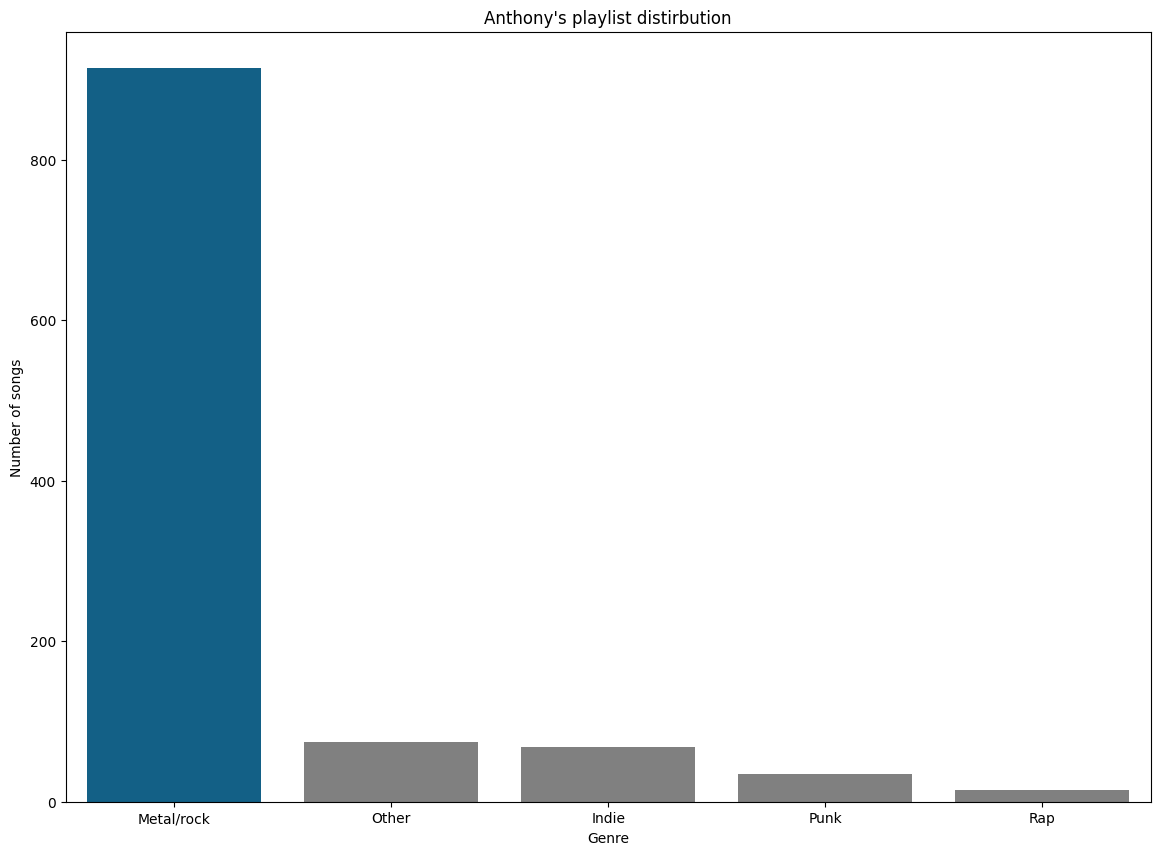

In [7]:
# Understanding my playlist 

genres = df_playlist['Genres'].value_counts().to_frame().reset_index()
genres = genres.rename(columns = {'index':'Genre' , 'Genres':'Number of songs'})
 
plt.figure(figsize=(14, 10))
sns.barplot(data=genres, x="Genre", y="Number of songs" , palette= ['#006699' , 'grey', 'grey' , 'grey',  'grey'],).set(title = "Anthony's playlist distirbution")
plt.savefig("/Users/anthonymoubarak/Desktop/anly-501-project-anthonymoub/501-project-website/Plots/Anthony_playlist.png")

After combining all the playlists, the final playlist/dataset has the following distribution of classes: 

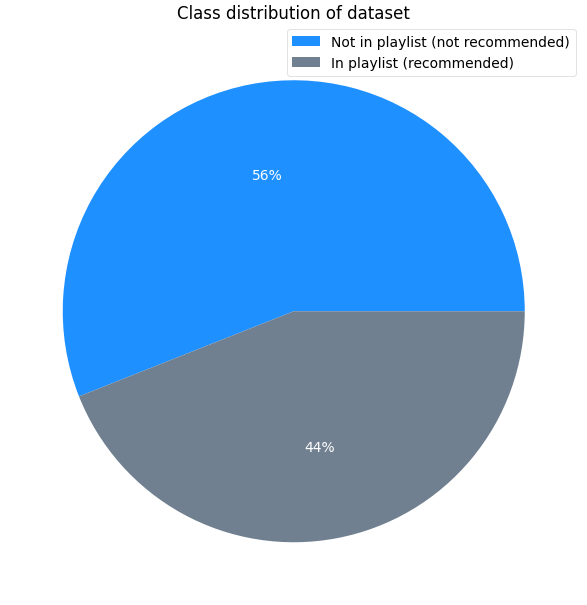

In [8]:
# Understanding how the classes are distributed
# 1 = songs in user playlist (my playlist in this example)
# 0 = songs not in user playlist

from tkinter import font


class_labels = df_all['In_playlist'].value_counts().to_frame().reset_index()
class_labels.columns = ['Label' , 'Count']


labels = ['Not in playlist (not recommended)', 'In playlist (recommended)']


colors = ['dodgerblue' , 'slategrey']

#create pie chart
plt.rcParams['figure.dpi'] = 50
plt.figure(figsize=(15,15))
font = {'size': 20}

plt.rc('font', **font)
plt.pie(class_labels['Count'], labels = labels, colors = colors, autopct='%.0f%%' , textprops={'color':"w"})
plt.legend()
plt.title('Class distribution of dataset')
plt.savefig("/Users/anthonymoubarak/Desktop/anly-501-project-anthonymoub/501-project-website/Plots/playlist_class_distribution.png")
plt.show()
 

In [9]:
df_in = df_all[df_all['In_playlist'] == 1]
df_out = df_all[df_all['In_playlist'] == 0]

In [10]:
# Comparing the distributions of several musical features between songs that are in the playlist with songs that are not in the playlist

df_all = pd.read_csv('/Users/anthonymoubarak/Desktop/anly-501-project-anthonymoub/501-project-website/Data/all_playlists.csv')
df_in = df_all[df_all['In_playlist'] == 1]
df_out = df_all[df_all['In_playlist'] == 0]



musical_features = ['Duration (ms)' , 'Danceability',
       'Energy', 'Key', 'Loudness', 'Mode', 'Speechiness', 'Acousticness',
       'Instrumentalness', 'Liveness', 'Valence', 'Tempo']


As the graph indicates, the dataset is well balanced between both classes and was a good dataset to start modeling on. The last exploratory step before modeling was understanding which features differ between classes and in what way, serving as a basic feature selection method to improve any model's predictive ability. The distribution plots of all the dataset's features in both playlists can be visualized below: 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


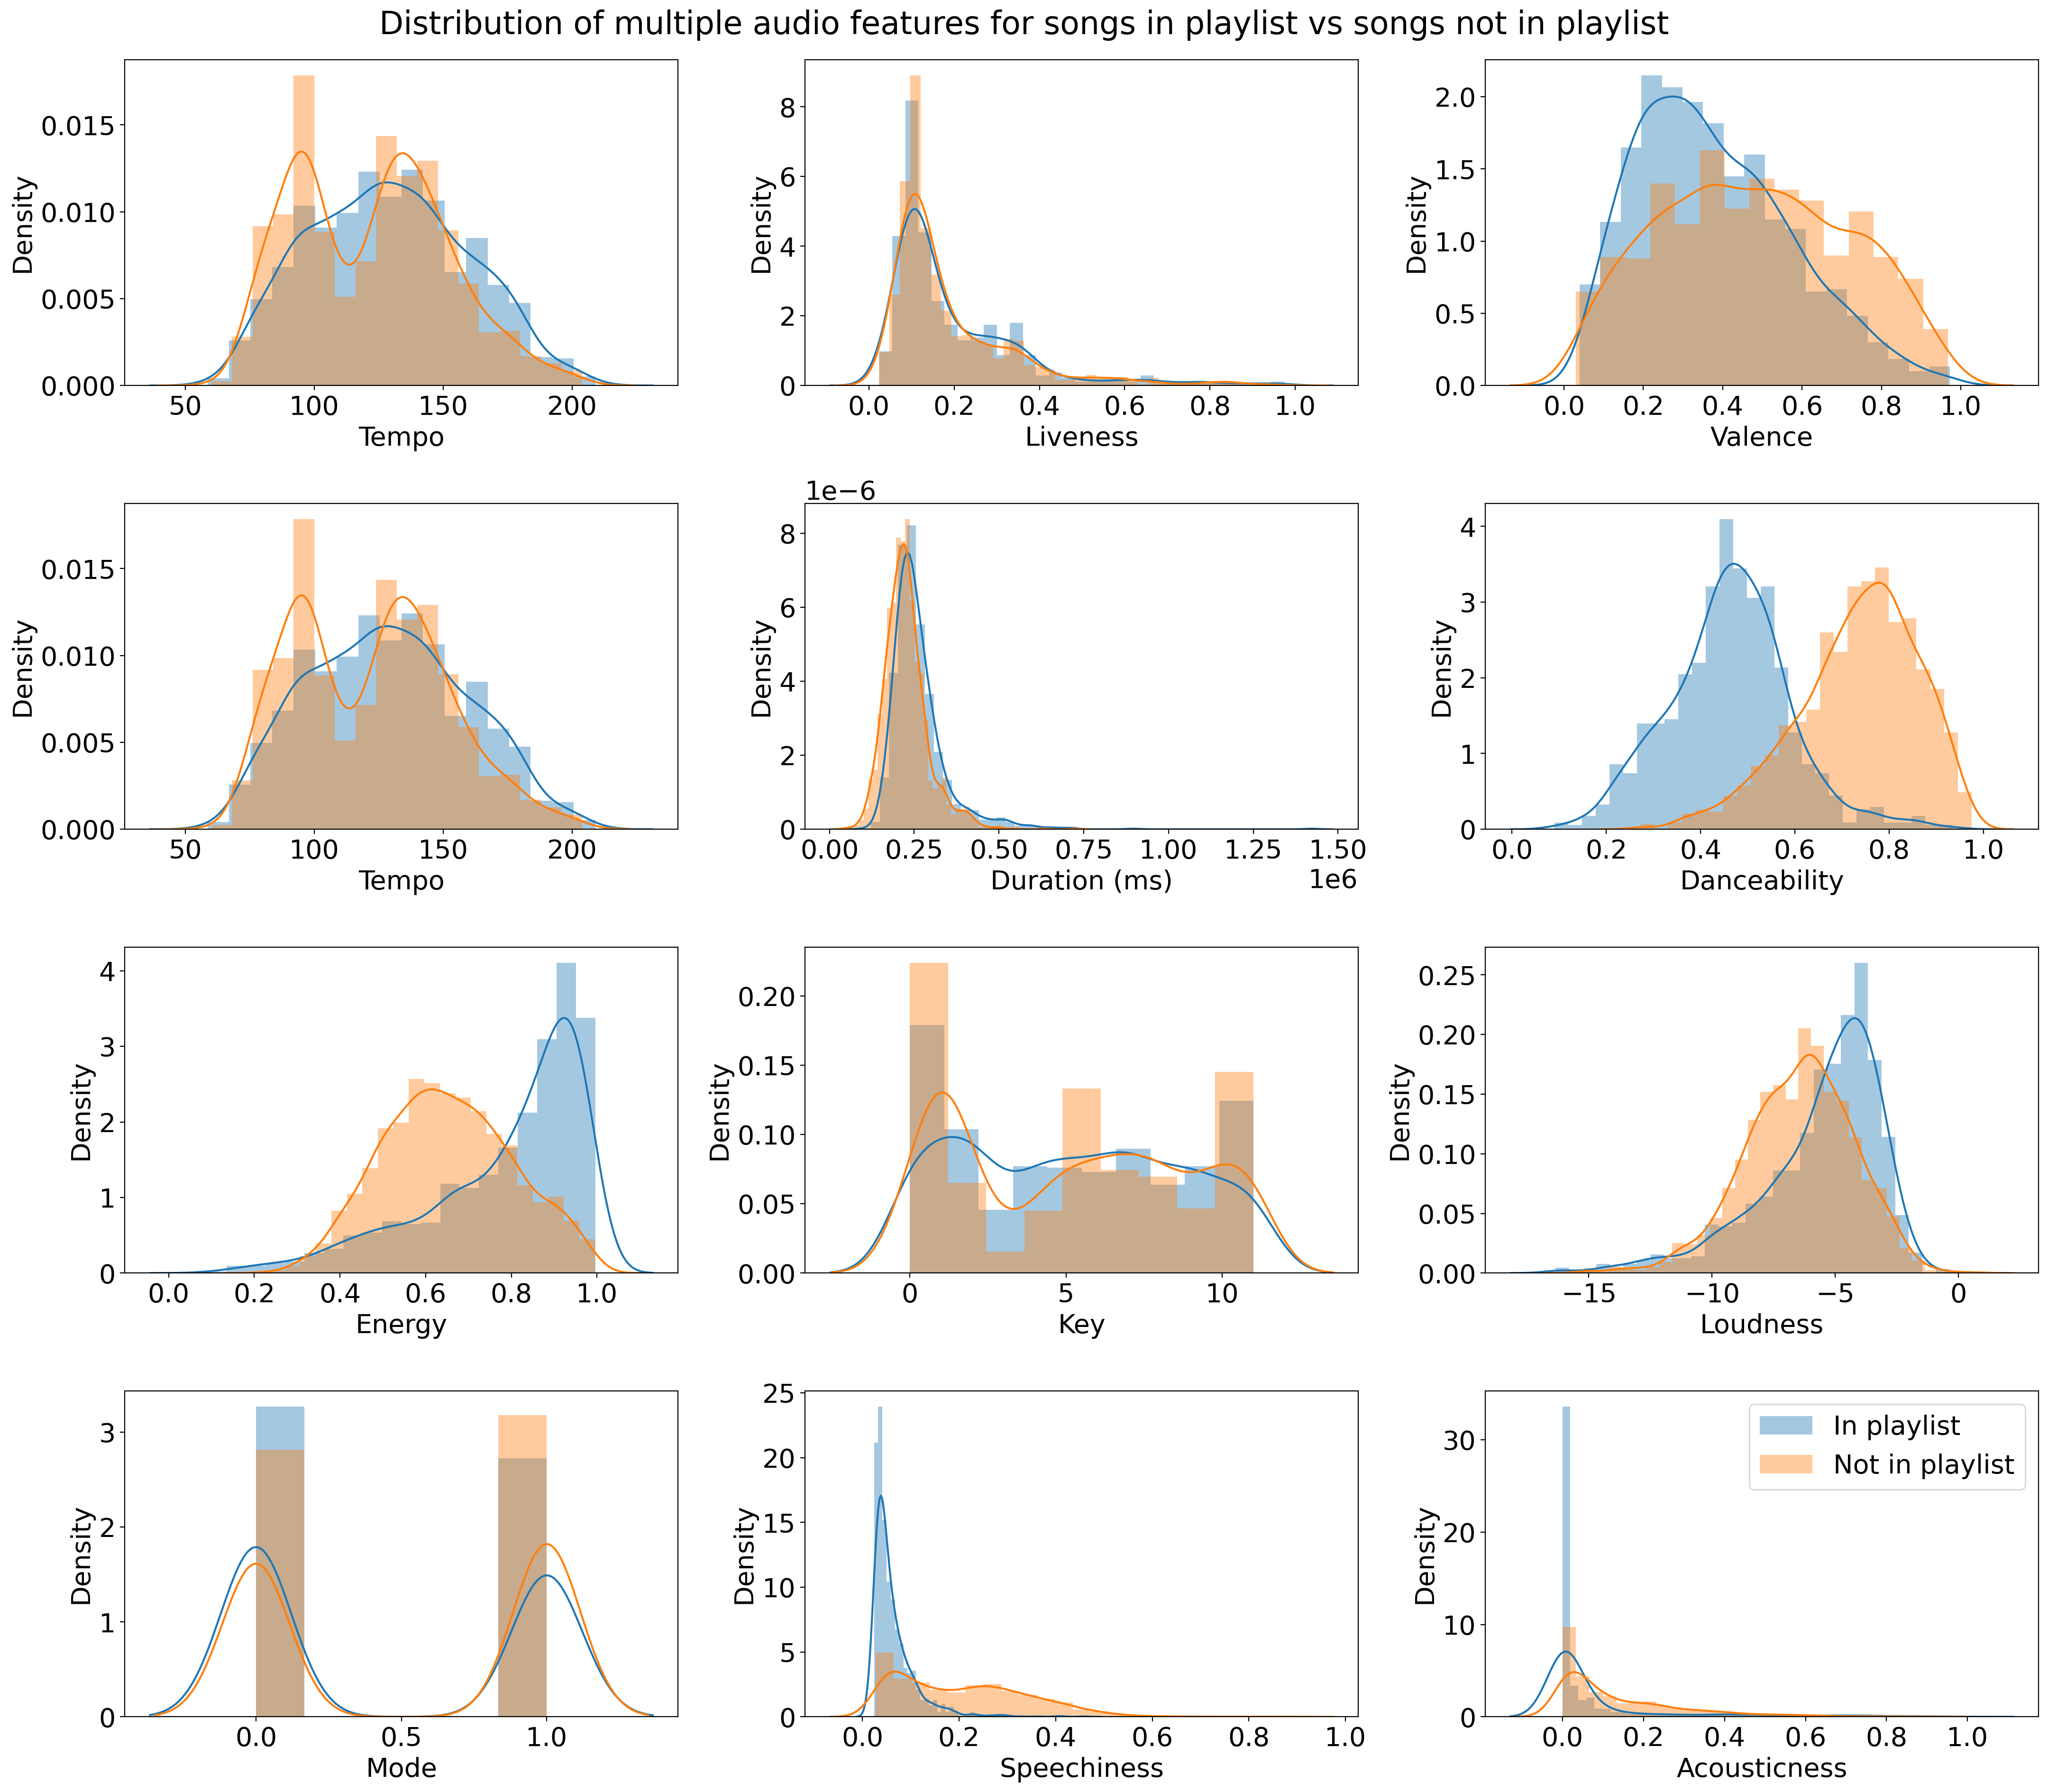

In [33]:
warnings.filterwarnings('ignore')
fig, axes = plt.subplots(4, 3, figsize = (22,20))


for i in np.arange(0,4):
    for j in np.arange(0,3):
        warnings.filterwarnings('ignore')
        if i == 1:
            warnings.filterwarnings('ignore')
            sns.distplot(df_in[str(musical_features[j-i])] , ax = axes[i , j] , label = 'Not in playlist')
            sns.distplot(df_out[str(musical_features[j-i])] , ax = axes[i , j] , label = 'Not in playlist')
             
        
        elif i == 2:
            sns.distplot(df_in[str(musical_features[i+j])] ,ax = axes[i , j] ,  label= 'In playlist')
            sns.distplot( df_out[str(musical_features[i+j])] , ax = axes[i , j] ,  label = 'Not in playlist')
             

        elif i == 3:
            warnings.filterwarnings('ignore')
            sns.distplot(df_in[str(musical_features[i+j+2])] , ax = axes[i , j] , label= 'In playlist')
            sns.distplot(df_out[str(musical_features[i+j+2])] ,ax = axes[i , j] ,  label = 'Not in playlist')
            plt.legend()

        else: 
            if j == 1:
                sns.distplot(df_in[str(musical_features[9])] ,ax = axes[i , j] ,  label= 'In playlist')
                sns.distplot(df_out[str(musical_features[9])] , ax = axes[i , j] , label = 'Not in playlist')
                 

            elif j == 2:
                sns.distplot(df_in[str(musical_features[10])] ,ax = axes[i , j] ,  label= 'In playlist')
                sns.distplot(df_out[str(musical_features[10])] , ax = axes[i , j] ,  label = 'Not in playlist')
                
            else:
                sns.distplot(df_in[str(musical_features[11])] , ax = axes[i , j])
                sns.distplot(df_out[str(musical_features[11])] , ax = axes[i , j])
fig.suptitle("Distribution of multiple audio features for songs in playlist vs songs not in playlist")
fig.tight_layout(rect=[0, 0.03, 1, 1])

The most main takeaways from the above distribution plots are: 

The features where there barely are any differences between both playlists are Liveness, Duration (ms), Key, and mode. These features were dropped to avoid unnecessary variables in my model. <br>
The biggest differences between playlists come from valence, danceability, energy, and speechiness. <br>
The remaining features moderately differ between both playlists might or might not have a significant impact.<br>

In [34]:
fig.savefig("/Users/anthonymoubarak/Desktop/anly-501-project-anthonymoub/501-project-website/Plots/Feature_dist_plot.png")

# Decision Tree modelling


Just like what was done with Naive Bayes, the first step was splitting the data into training and testing data (80% train, 20% test). Next, Python's sklearn library was used to build a decision tree model on the training and later use it on the testing data to check the accuracy. One of the main disadvantages of decision trees is tendency for overfitting. 

Overfitting refers to the condition when the model completely fits the training data but fails to generalize the testing unseen data. Overfit condition arises when the model memorizes the noise of the training data and fails to capture important patterns. A perfectly fit decision tree performs well for training data but performs poorly for unseen test data. 

There are many ways to avoid an overfit decision tree, one of which is calculating the training and testing accuracies for different values of max_depth and get the optimal point accordingly. Max_depth is a decision tree hyperparameter that controls the maximum depth of the tree that will be created and the optimal point is the depth level at which the training error monotonously increases and testing error monotonously decreases after that depth. 

The max_depth vs training/validation error relationship can be seen in the graph below: 

In [12]:
# Split data into training and testing after dropping some useless columns (no impact if recommended or not).
# The dropped features are: Liveness, Duration (ms), Key, and mode

from sklearn.model_selection import train_test_split

features = [  'Danceability', 'Energy', 'Loudness', 'Speechiness',
       'Acousticness', 'Instrumentalness',  'Valence', 'Tempo',
       'Time Signature']
X = df_all[features]
Y = df_all['In_playlist']

# Normalize the data 
X = (X-X.mean())/X.std()


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [13]:
# Train model 

from sklearn import tree
model = tree.DecisionTreeClassifier()
model = model.fit(X_train , Y_train)

In [14]:
# Test results
yp_train = model.predict(X_train)
yp_test = model.predict(X_test)

sum(yp_test == Y_test)/len(Y_test)

0.9182509505703422

In [15]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.datasets import make_classification


def confusion_plot(y_data , y_pred):
    ConfusionMatrixDisplay.from_predictions(
     y_data, y_pred, cmap='Blues')

    plt.show()


    def perf_measure(y_actual, y_hat):
        TP = 0
        FP = 0
        TN = 0
        FN = 0

        for i in range(len(y_hat)): 
            try:
                if (y_actual[i]==y_hat[i]) ==1:
                    TP += 1
                if (y_hat[i]==1) and (y_actual[i]!=y_hat[i]):
                    FP += 1
                if (y_actual[i]==y_hat[i]) ==0:
                    TN += 1
                if (y_hat[i]==0) and (y_actual[i]!=y_hat[i]):
                    FN += 1
            except:
                continue

        TP = TP/100
        FP = FP/100
        TN = TN/100
        FN = FN/100

        accuracy = sum(y_actual == y_hat)/(len(y_hat))
        negative_recall = TN/(TN + FP)
        positive_recall = TP/(TP + FN)
        negative_precision = TN/(TN + FN)
        positive_precision = TP/(TP + FP)

        print('ACCURACY: ' + str(accuracy))
        print('NEGATIVE RECALL: ' + str(negative_recall))
        print('POSITIVE RECALL: ' + str(positive_recall))
        print('NEGATIVE PRECISION: ' + str(negative_precision))
        print('POSITIVE PRECISION: ' + str(positive_precision))

    perf_measure(y_data , y_pred)

------TRAINING------


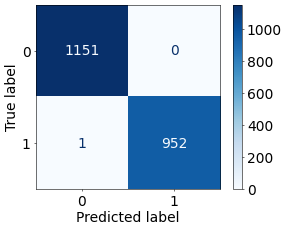

ACCURACY: 0.9995247148288974
NEGATIVE RECALL: 0.7245873153779322
POSITIVE RECALL: 0.6226277372262774
NEGATIVE PRECISION: 0.6173205033308661
POSITIVE PRECISION: 0.729059829059829
------TEST------


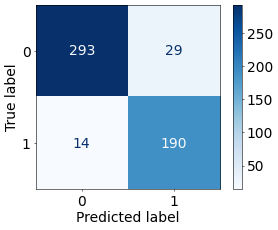

ACCURACY: 0.9182509505703422
NEGATIVE RECALL: 0.5972222222222222
POSITIVE RECALL: 0.971830985915493
NEGATIVE PRECISION: 0.7543859649122806
POSITIVE PRECISION: 0.943359375


In [16]:
X_train.reset_index(drop = True)
X_test.reset_index(drop = True)
Y_train.reset_index(drop = True)
Y_test.reset_index(drop = True)


print("------TRAINING------")
confusion_plot(Y_train,yp_train)
print("------TEST------")
Y_test = Y_test.reset_index(drop = True)
confusion_plot(Y_test,yp_test)

# Hyperparameter tuning


In [17]:
# Iterate over several values of the "max_depth" parameter and find the point at which training AND testing score are the lowest, to avoid overfitting
test_results=[]
train_results=[]

for num_layer in range(1,20):
    model = tree.DecisionTreeClassifier(max_depth=num_layer)
    model = model.fit(X_train, Y_train)

    yp_train=model.predict(X_train)
    yp_test=model.predict(X_test)

    # print(y_pred.shape)
    test_results.append([num_layer,accuracy_score(Y_test, yp_test),recall_score(Y_test, yp_test,pos_label=0),recall_score(Y_test, yp_test,pos_label=1)])
    train_results.append([num_layer,accuracy_score(Y_train, yp_train),recall_score(Y_train, yp_train,pos_label=0),recall_score(Y_train, yp_train,pos_label=1)])

In [18]:
# Convert arrays to dataframes to be used in plotting
test_results_df = pd.DataFrame(test_results, columns=['n' , 'Accuracy', 'Recall(Y=0)', 'Recall(Y=1)'])
train_results_df = pd.DataFrame(train_results, columns=['n' , 'Accuracy', 'Recall(Y=0)', 'Recall(Y=1)'])

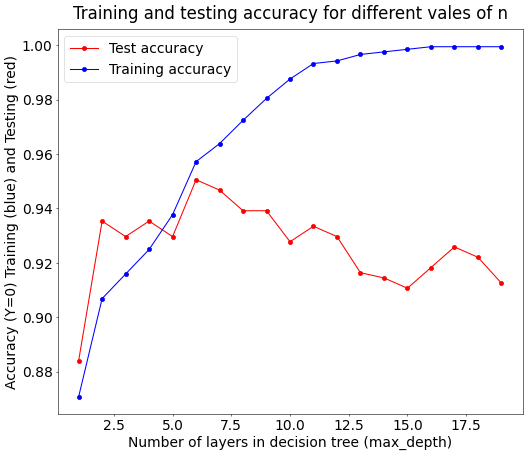

In [19]:
# Plot the max_depth vs accuracies to optimize model
plt.rcParams['figure.dpi'] = 50
plt.figure(figsize = (12,10))
plt.plot(test_results_df['n'], test_results_df['Accuracy'], label = 'Test accuracy', color = 'red', linestyle = 'solid', marker = "o" )
plt.plot(train_results_df['n'], train_results_df['Accuracy'], label = 'Training accuracy', color = 'blue', linestyle = 'solid', marker = "o")
plt.legend()
plt.title('Training and testing accuracy for different vales of n' , pad = 15)
plt.xlabel("Number of layers in decision tree (max_depth)")
plt.ylabel("Accuracy (Y=0) Training (blue) and Testing (red)")
plt.savefig("/Users/anthonymoubarak/Desktop/anly-501-project-anthonymoub/501-project-website/Plots/max_depth.png")


The graph indicates to us that a max depth of n = 6 is the best option for the decision tree we have built as any depth after that will cause the model to over fit and perform poorly with data other than the training data. The fact that after n = 6 the training error keeps on increasing while the testing keeps on decreasing validates that idea.

After getting the optimal max_depth for our decision tree (which was 6), the next step was fitting a decision tree with this value of max depth and testing several of its metrics, which are detailed below: 


In [20]:
from sklearn import tree
optimal_model = tree.DecisionTreeClassifier(max_depth= 6)
optimal_model = optimal_model.fit(X_train, Y_train)

yp_train=model.predict(X_train)
yp_test=model.predict(X_test)

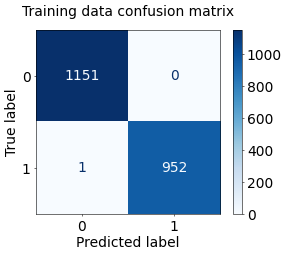

In [21]:
ConfusionMatrixDisplay.from_predictions(
     Y_train, yp_train, cmap='Blues')


plt.title('Training data confusion matrix' ,  fontdict = {'fontsize' : 20} , pad= 20)

plt.savefig("/Users/anthonymoubarak/Desktop/anly-501-project-anthonymoub/501-project-website/Plots/Opt_model_train.png" ,dpi=300, bbox_inches = "tight")
plt.show()

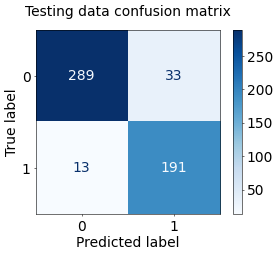

In [22]:
plt.rcParams['figure.dpi'] = 50
ConfusionMatrixDisplay.from_predictions(
     Y_test, yp_test, cmap='Blues')

plt.title('Testing data confusion matrix' ,  fontdict = {'fontsize' : 20} , pad= 20)
plt.savefig("/Users/anthonymoubarak/Desktop/anly-501-project-anthonymoub/501-project-website/Plots/Opt_model_test.png"  ,dpi=300, bbox_inches = "tight")
plt.show()

------TRAINING------


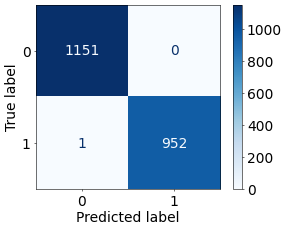

ACCURACY: 0.9995247148288974
NEGATIVE RECALL: 0.7245873153779322
POSITIVE RECALL: 0.6226277372262774
NEGATIVE PRECISION: 0.6173205033308661
POSITIVE PRECISION: 0.729059829059829


AttributeError: 'NoneType' object has no attribute 'save'

In [23]:
print("------TRAINING------")
confusion_plot(Y_train,yp_train).save
print("------TEST------")
confusion_plot(Y_test,yp_test)

Below are the definitions of each of the above metrics:

Accuracy: % of correct predictions. <br>
Precision: The precision of a model describes how many detected items are truly relevant. It is calculated by dividing the true positives by overall positives. <br>
Recall: Recall is a measure of how many relevant elements were detected. Therefore it divides true positives by the number of relevant elements. <br>

My model performed very well in terms of accuracy (99% training and 89% testing) and precision (93% for test set), indicating that the model has good predictive ability when it comes to predicting true positives. In production terms, my model has a good chance of detecting whether a song will actually make a playlist and the mistakes would occur by not recommending what would have been a recommended worthy song (low negative recall score). 

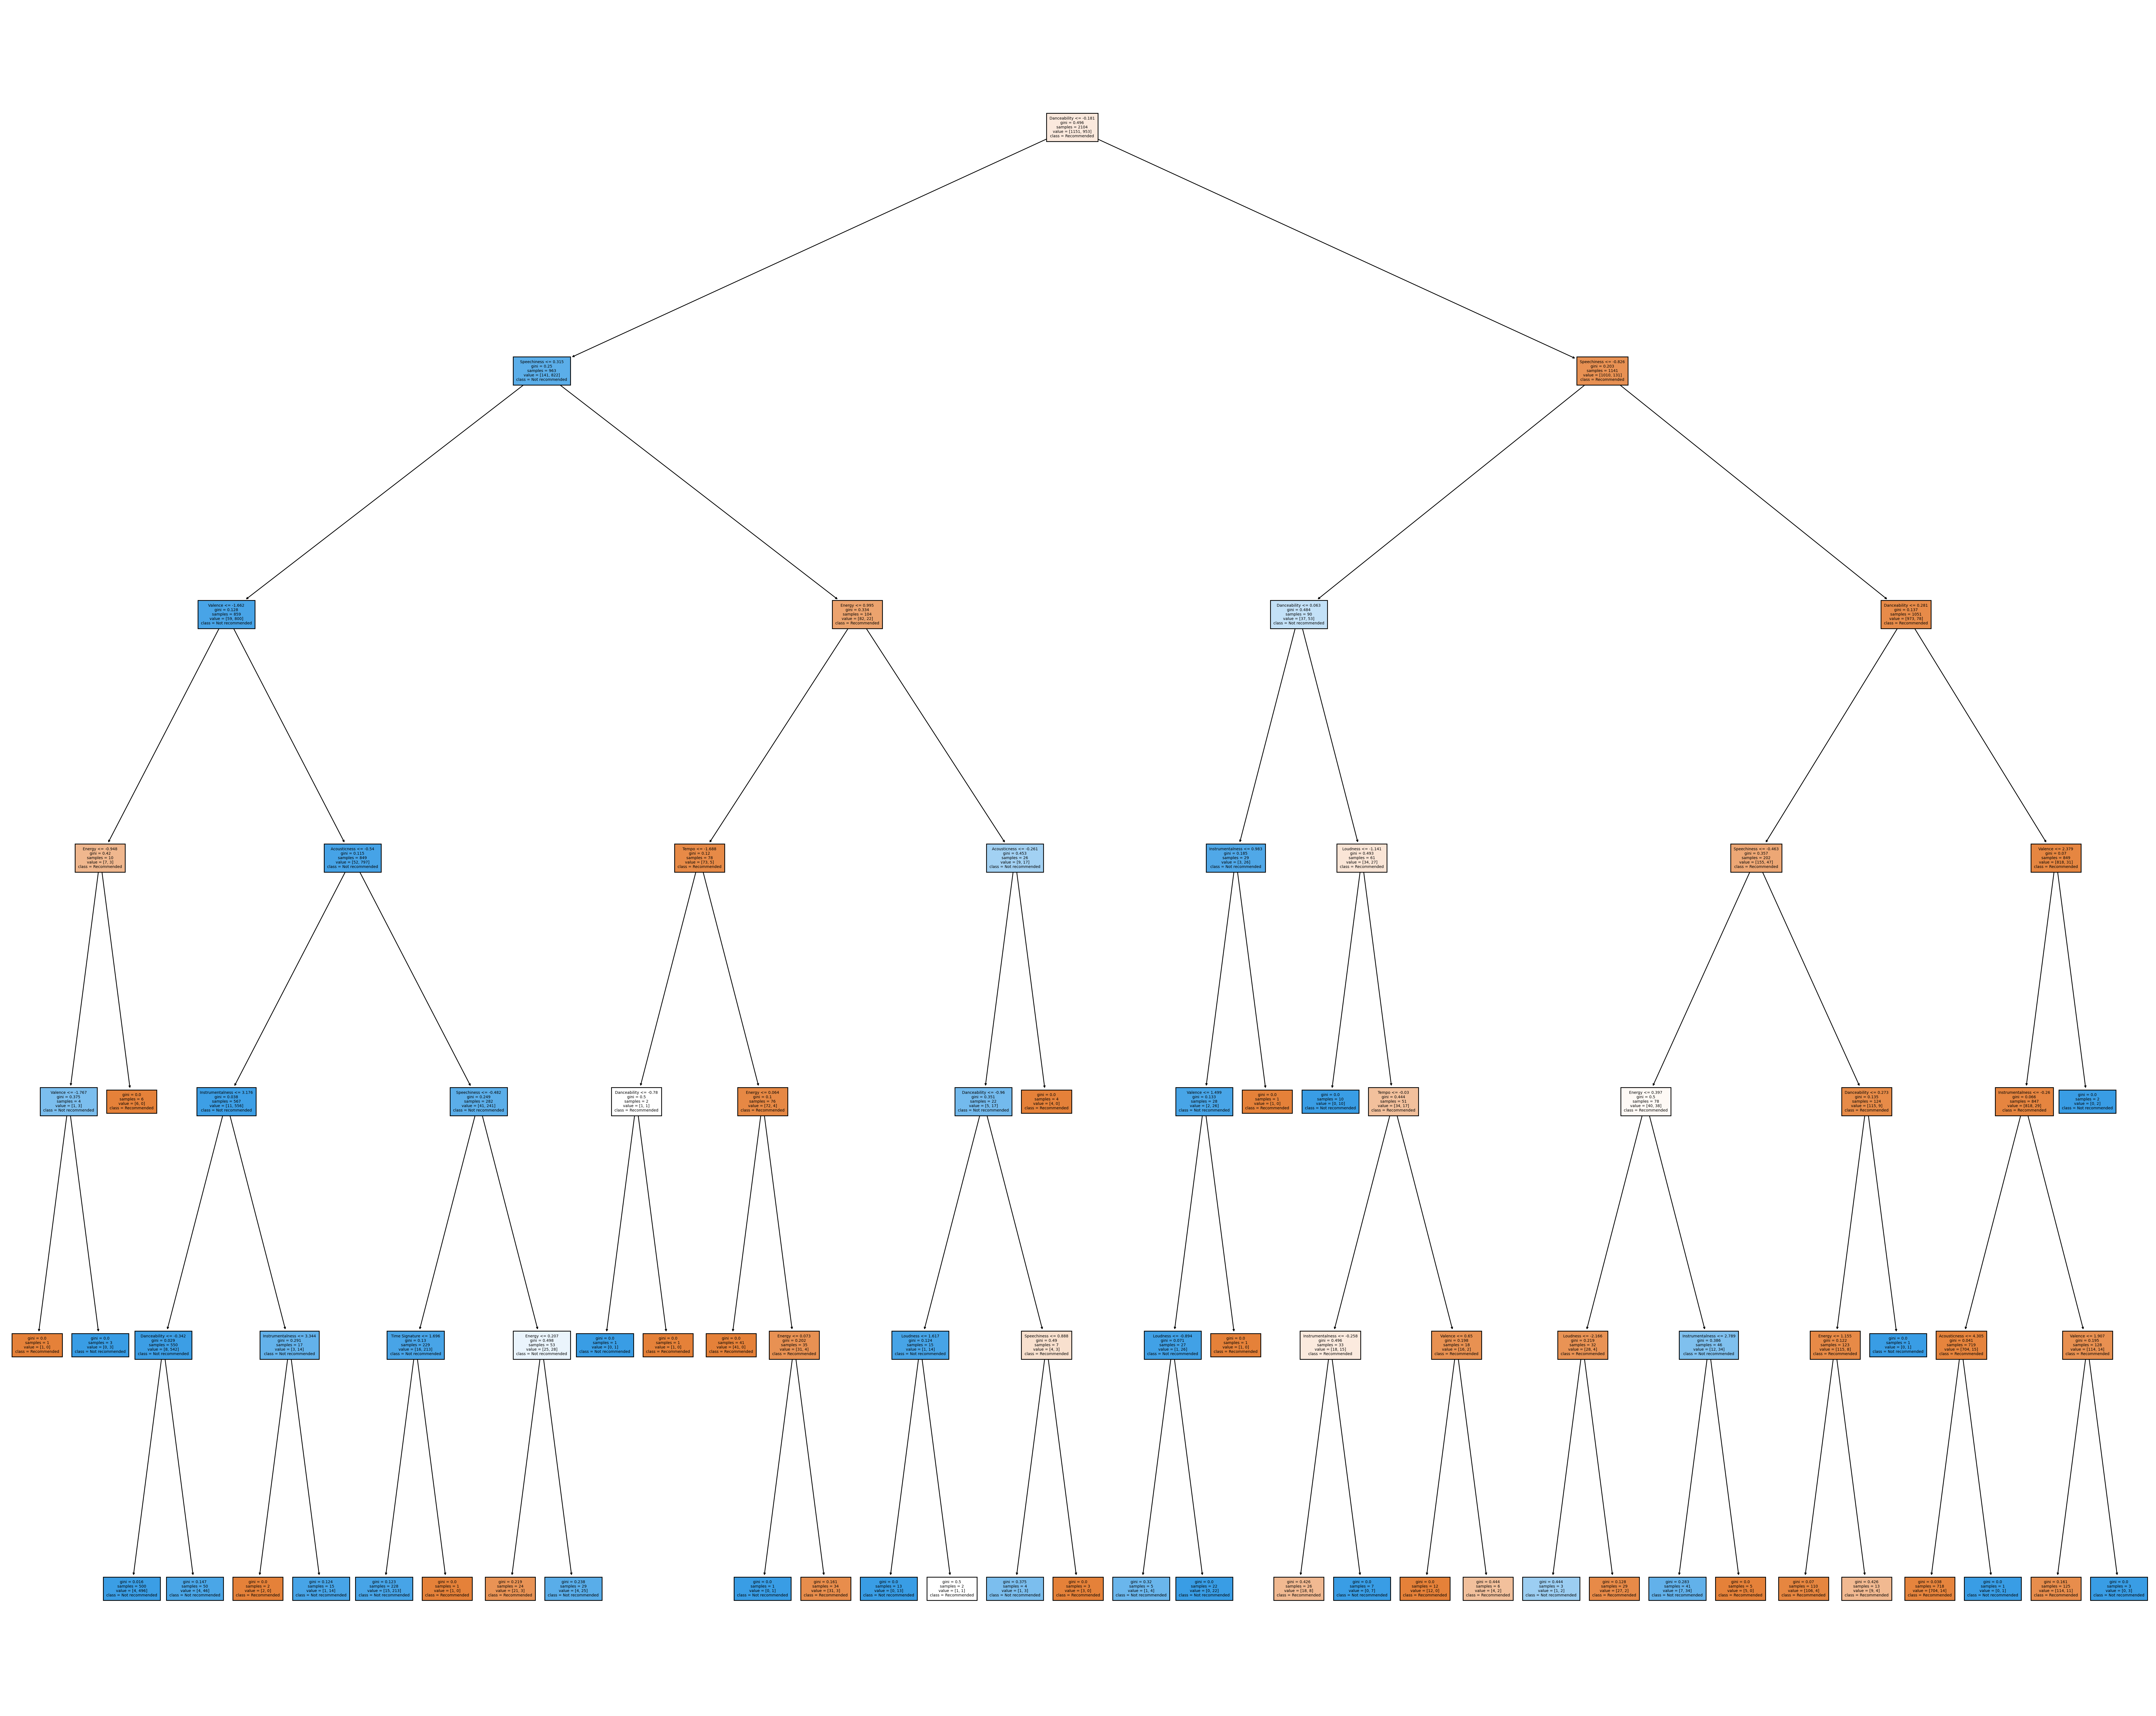

In [28]:
# Visualize the tree

from sklearn import tree

plt.figure(figsize=(50,40))
plt.rcParams['figure.dpi'] = 200
tree.plot_tree(optimal_model, 
                   feature_names=X.columns,  
                   class_names=['Recommended' , "Not recommended"],
                   filled=True,
                   fontsize=5)
plt.savefig("/Users/anthonymoubarak/Desktop/anly-501-project-anthonymoub/501-project-website/Plots/Decision_tree.png"  ,dpi=300, bbox_inches = "tight")

# Random Forest 


Essentially, a random forest is an algorithm which combines the output of multiple decision trees to reach a single result using ensemble methods. Everything I had done so far and explained above is used one single decision tree as my classifier, which has 2 main disadvantages: 

1. A small change in the data can cause massive change in the structure of the decision tree, as it is very dependent on where the first split occurs. This causes the model to be highly unstable. <br>
2. Decision trees have a tendency to over fit. <br>

Random forests compensate for these disadvantages by training multiple decision trees (at different splits) and generate a single result out of all of them. Also, random forests have a built in feature selection process that makes sure only relevant features are used by the model.
The random forest model gave me a final 100% training accuracy and a 92% testing accuracy, both of which were an improvement from my optimized decision tree.

In [135]:
# creating a RF classifier
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators = 100) 

random_forest.fit(X_train, Y_train)
 

y_pred_rf = random_forest.predict(X_test)

In [137]:
from sklearn import metrics 

print('Training accuracy: ' , metrics.accuracy_score(Y_train, Y_train))
print('Testing accuracy: ' , metrics.accuracy_score(Y_test, y_pred_rf))


Training accuracy:  1.0
Testing accuracy:  0.9258555133079848


# Conclusion

Overall, the use of decision trees and random forests was a success, were they where both able to accurately (90% +) classify a song as recommended or not recommended to my playlist based on the playlist itself. The use cases and production environment in which these models could be used in are discussed in the 'Implementation' tab. (The tab has still not been developed at this stage of the project)